### Interpretability of DNN: Visualization of extreme events

In [ ]:
# Calculate LRP for specific dates and plot

In [1]:
# Important to note:!
# The use of innvestigate requires specific versions of python and keras
# The model must be built according to the versions, so the weights are saved separately
# import necesssary libaries
from pathlib import Path
import pathlib
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
#for plotting
import geopandas as gpd

from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

from utils.utils_unet import *
from utils.utils_plot import *
from utils.DNN_models import *
from utils.utils_LRP import *


import innvestigate
import innvestigate.utils as iutils
import innvestigate.applications.imagenet
import innvestigate.utils.visualizations as ivis

import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')  #catch FutureWarnings so that I can find actual errors!
    
    import keras
    import keras.backend as K
    import keras.models
    #import tensorflow as tf  # this is new for custom loss function
    from keras.models import load_model
    
    from keras.layers import Input, Dense, Activation, Dropout, Flatten, MaxPooling2D, Conv2D, Conv2DTranspose, UpSampling2D, Reshape
    from keras.models import Model
    
    from keras.utils import CustomObjectScope
    from keras.initializers import glorot_uniform

Using TensorFlow backend.


In [2]:
import yaml
conf = yaml.safe_load(open("config.yaml"))

In [3]:
i_shape = conf['i_shape']
o_shape = conf['o_shape']

print(f'X shape: {i_shape}')
print(f'y shape: {o_shape}')
output_channels = conf['output_channels']
num_filters = conf['num_filters']
use_batchnorm = conf['use_batchnorm']
dropout = conf['dropout']
lr = conf['lr']

name_model = conf['model']
output_scaling = 1
output_crop = None


# load coordinates
lons_x = np.load('tmp/data/lons_y.npy')
lats_y = np.load('tmp/data/lats_y.npy')
# create a time array
#times = np.arange(np.datetime64('1979-01-01'), np.datetime64('2006-01-01')) #until validation period
#times = pd.to_datetime(times)
# load the training and testing data
#dg_train_X = np.array(xr.open_dataarray('tmp/data/dg_train_X.nc'))
#dg_train_Y = np.array(xr.open_dataarray('tmp/data/dg_train_Y.nc'))
#dg_train_Y_xtrm = np.array(xr.open_dataarray('tmp/data/dg_train_Y_xtrm.nc'))

times = np.arange(np.datetime64('2016-01-01'), np.datetime64('2022-01-01')) #until validation period
times = pd.to_datetime(times)
dg_test_X = np.array(xr.open_dataarray('tmp/data/dg_test_X.nc'))
#dg_test_Y = np.array(xr.open_dataarray('tmp/data/dg_test_Y.nc'))
#dg_test_Y_xtrm = np.array(xr.open_dataarray('tmp/data/dg_test_Y_xtrm.nc'))

# Define hyperparameters
EPOCHS = 100
LR_METHOD = 'Constant'  # Cyclical, CosineDecay, Constant
                                            
# Default model options
opt_model = {'latent_dim': 128,
             'dropout_rate': 0.2}

# Default optimizer options
opt_optimizer = {'lr_method': 'Constant',
                 'lr': 0.0004,
                 'init_lr': 0.01}

models = {
          'UNET1': {'model': 'Unet', 'run': True,
                   'opt_model': {'output_scaling': output_scaling, 'output_crop': output_crop, 'unet_depth': 1, 'unet_use_upsample': True},
                   'opt_optimizer': {'lr_method': 'Constant'}},
          'UNET2': {'model': 'Unet', 'run': True,
                   'opt_model': {'output_scaling': output_scaling, 'output_crop': output_crop, 'unet_depth': 2, 'unet_use_upsample': True},
                   'opt_optimizer': {'lr_method': 'Constant'}},
          'UNET3': {'model': 'Unet', 'run': True,
                   'opt_model': {'output_scaling': output_scaling, 'output_crop': output_crop, 'unet_depth': 3, 'unet_use_upsample': True},
                   'opt_optimizer': {'lr_method': 'Constant'}},
          'UNET4': {'model': 'Unet', 'run': True,
                   'opt_model': {'output_scaling': output_scaling, 'output_crop': output_crop, 'unet_depth': 4, 'unet_use_upsample': True},
                   'opt_optimizer': {'lr_method': 'Constant'}},
          'UNET-att': {'model': 'Unet-attention', 'run': True,
                   'opt_model': {'output_scaling': output_scaling, 'output_crop': output_crop},
                   'opt_optimizer': {'lr_method': 'Constant'}},
          'UNET1-att': {'model': 'Unet-attention', 'run': True,
                       'opt_model': {'output_scaling': output_scaling, 'output_crop': output_crop, 'unet_depth': 1, 'unet_use_upsample': True},
                       'opt_optimizer': {'lr_method': 'Constant'}}
            }



X shape: [46, 56, 31]
y shape: [46, 56, 1]


In [4]:
##############LRP ###########
# Select one model to evaluate the LRP
m_id = 'UNET4'
model = models[m_id]['model']
opt_model_i = models[m_id]['opt_model']
opt_optimizer_i = models[m_id]['opt_optimizer']

opt_model_new = opt_model.copy()
opt_model_new.update(opt_model_i)
opt_optimizer_new = opt_optimizer.copy()
opt_optimizer_new.update(opt_optimizer_i)


m = DeepFactory_Keras(model, i_shape, o_shape, for_extremes=True,**opt_model_new)

# compile 
m.model.compile(loss=keras.losses.categorical_crossentropy, ## instead of CategoricalCrossentropy
                  optimizer='adam', ## lr instead of learning_rate
                  metrics=['categorical_accuracy'])

print('loads weigths')
#m.model.summary()
# load weights
m.model.load_weights('tmp/tmp_weights_DNN/UNET40.95th_trained_weights.h5')

loads weigths


In [5]:
#load NULL model
m1 = DeepFactory_Keras(model, i_shape, o_shape, for_extremes=True,**opt_model_new)

# compile 
m1.model.compile(loss=keras.losses.categorical_crossentropy, ## instead of CategoricalCrossentropy
                  optimizer='adam', ## lr instead of learning_rate
                  metrics=['categorical_accuracy'])

print('loads weigths')
#m.model.summary()
# load weights
m1.model.load_weights('tmp/tmp_weights_DNN/UNET4_NULL_0.95th_trained_weights.h5')

loads weigths


In [23]:
#load NULL model
m2 = DeepFactory_Keras(model, i_shape, o_shape, for_extremes=False,**opt_model_new)

# compile 
m2.model.compile(loss=keras.losses.categorical_crossentropy, ## instead of CategoricalCrossentropy
                  optimizer='adam', ## lr instead of learning_rate
                  metrics=['categorical_accuracy'])

print('loads weigths')
#m.model.summary()
# load weights
m2.model.load_weights('tmp/tmp_weights_DNN/UNET4_NULL_pr_trained_weights.h5')

loads weigths


In [6]:
# load data
# coordinates
lons_x = np.load('tmp/data/lons_y.npy')
lats_y = np.load('tmp/data/lats_y.npy')

In [7]:
# test-times
times = np.arange(np.datetime64('2016-01-01'), np.datetime64('2021-12-31'))
times = pd.to_datetime(times)
# load the training and testing data
dg_test_Y_xtrm = np.array(xr.open_dataarray('tmp/data/dg_test_Y_xtrm0.95th.nc'))

In [8]:
#load predictions --numpy array
y_pred1_test = np.load('tmp/data/y_pred_test_UNET10.95th.npy')
y_pred4_test = np.load('tmp/data/y_pred_test_UNET40.95th.npy')
y_pred1_bool = y_pred1_test >= 0.5
y_pred1_bool = y_pred1_bool * 1
y_pred4_bool = y_pred4_test >= 0.5
y_pred4_bool = y_pred4_bool * 1

In [9]:
#select one day # e.g. select the flood in July 2021, days: 12-15
idx = np.where(times == '2021-07-14')

In [10]:
idx = int(idx[0])

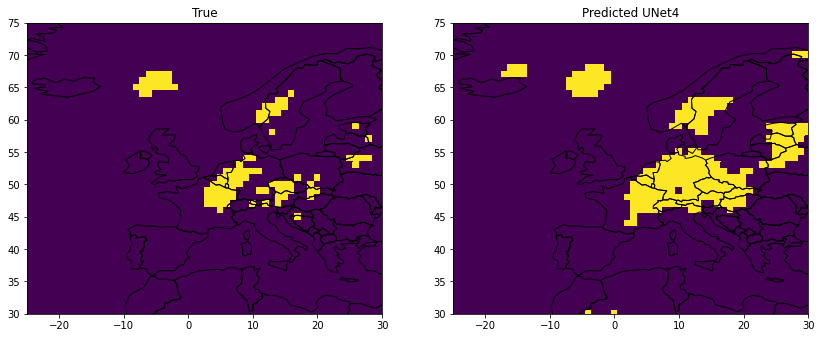

In [11]:
#select one day and plot
fig, ax = plt.subplots(figsize=(14, 8), ncols=2, nrows=1)
plot_map(ax[0], lons_x, lats_y, dg_test_Y_xtrm[idx,:,:,0], title="True", vmin=0, vmax=1,  show_colorbar=False)
plot_map(ax[1], lons_x, lats_y, y_pred4_bool[idx,:,:], title="Predicted UNet4", vmin=0, vmax=1, show_colorbar=False)

In [12]:
fig.savefig('figures/14July2021_predicted_true_nocolorbar.pdf')

In [14]:
# As in the main notebook, also analyse the day with the highest amoung of observed precipitation (it corresponds to Hurricane Leslie that evolved to storms-reported heavy precipitation
# Get the index of the max # of extremes
i_max_obs = np.argmax(np.sum(dg_test_Y_xtrm, axis=(1,2)))

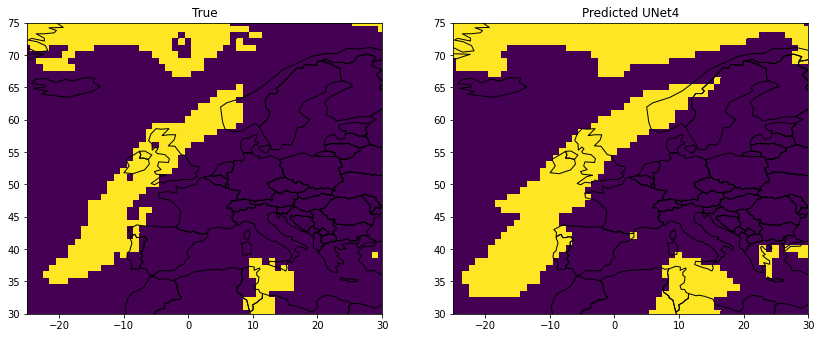

In [15]:
#select one day and plot
fig, ax = plt.subplots(figsize=(14, 8), ncols=2, nrows=1)
plot_map(ax[0], lons_x, lats_y, dg_test_Y_xtrm[i_max_obs,:,:,0], title="True", vmin=0, vmax=1,  show_colorbar=False)
plot_map(ax[1], lons_x, lats_y, y_pred4_bool[i_max_obs,:,:], title="Predicted UNet4", vmin=0, vmax=1, show_colorbar=False)

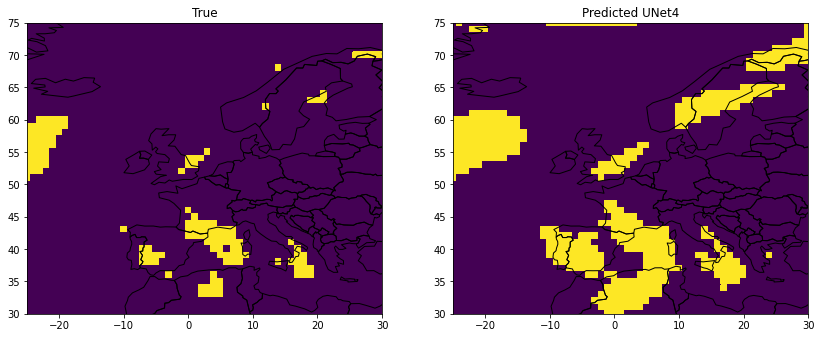

In [16]:
fig, ax = plt.subplots(figsize=(14, 8), ncols=2, nrows=1)
plot_map(ax[0], lons_x, lats_y, dg_test_Y_xtrm[i_max_obs +2 ,:,:,0], title="True", vmin=0, vmax=1,  show_colorbar=False)
plot_map(ax[1], lons_x, lats_y, y_pred4_bool[i_max_obs +2 ,:,:], title="Predicted UNet4", vmin=0, vmax=1, show_colorbar=False)

In [13]:
nx = dg_test_X.shape[1]
ny = dg_test_X.shape[2]
nchans = dg_test_X.shape[3]

In [18]:
###Get the samples to analyze and choose a date to analyze
my_sample = dg_test_X[idx,:,:,:]
n_samples_to_analyze = 1
# Get the sample
my_sample = my_sample.reshape(n_samples_to_analyze,nx,ny,nchans)
# my  prediction for that sample
#my_estimate = y_pred_test[idx,:]

In [15]:
i_max_obs=1016

In [17]:
# event 2021
rel_U4_2021= calLRP(dg_test_X[idx-1:idx+2,:,:,:],m.model, 'lrpz', only_positive=False )
# event 2018
rel_U4_2018= calLRP(dg_test_X[i_max_obs:i_max_obs+3,:,:,:],m.model, 'lrpz', only_positive=False )

In [18]:
# event 2021
rel_U4comp_2021= calLRP(dg_test_X[idx-1:idx+2,:,:,:],m.model, 'comp', only_positive=False )
# event 2018
rel_U4comp_2018= calLRP(dg_test_X[i_max_obs:i_max_obs+3,:,:,:],m.model, 'comp', only_positive=False )

In [19]:
# event 2021
rel_U4compflat_2021= calLRP(dg_test_X[idx-1:idx+2,:,:,:],m.model, 'compflat', only_positive=False )
# event 2018
rel_U4complat_2018= calLRP(dg_test_X[i_max_obs:i_max_obs+3,:,:,:],m.model, 'compflat', only_positive=False )

In [20]:
# event 2021
rel_U4_alpha_2021= calLRP(dg_test_X[idx-1:idx+2,:,:,:],m.model, 'a1b0', only_positive=False )
# event 2018
rel_U4_alpha_2018= calLRP(dg_test_X[i_max_obs:i_max_obs+3,:,:,:],m.model, 'a1b0', only_positive=False )

In [24]:
# Testing with other methods
#rel_U4= calLRP(dg_test_X[i_max_obs:i_max_obs+4,:,:,:],m.model, 'deep_taylor' )
#rel_U4_grad= calLRP(dg_test_X[i_max_obs:i_max_obs+4,:,:,:],m.model, 'gradient', False )

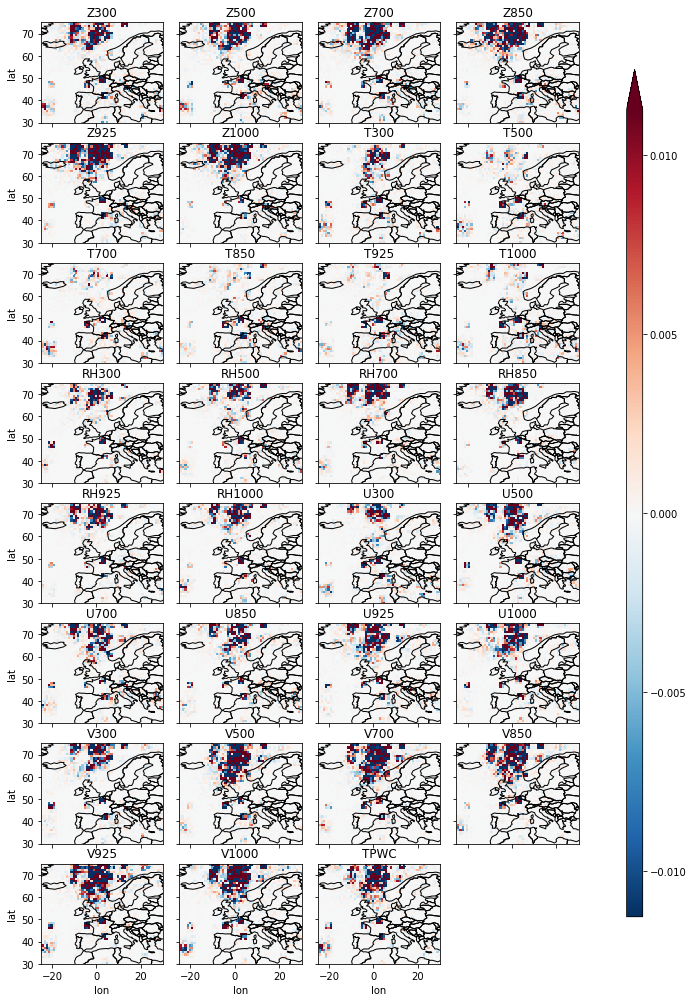

In [26]:
plot_xr_rel(rel_U4_2018[0,:,:,:], lats_y, lons_x, conf['varnames'], 'highest_amount_precip_lrpz', cmap = 'RdBu_r')

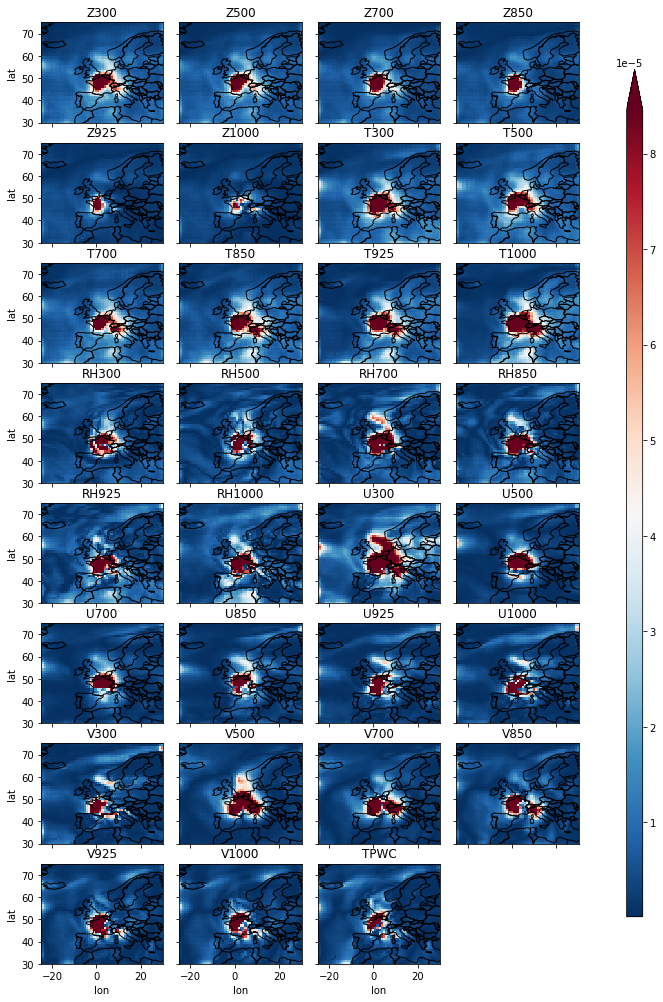

In [28]:
plot_xr_rel(rel_U4comp_2021[0,:,:,:], lats_y, lons_x, conf['varnames'], 'highest_amount_precip_comp', cmap = 'RdBu_r')

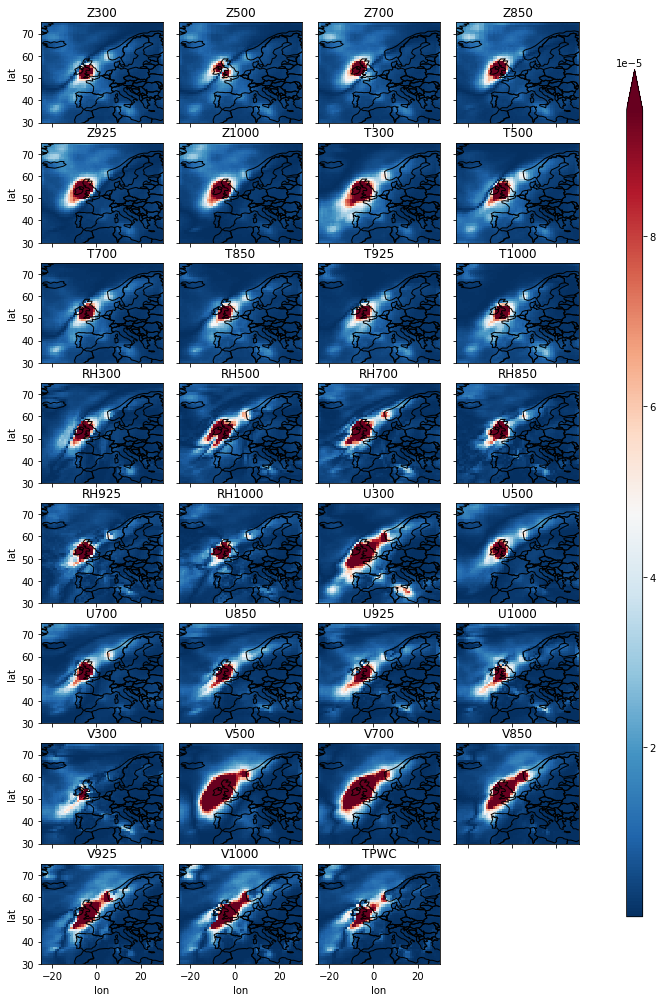

In [30]:
plot_xr_rel(rel_U4complat_2018[0,:,:,:], lats_y, lons_x, conf['varnames'], 'highest_amount_precip_compflat', cmap = 'RdBu_r')

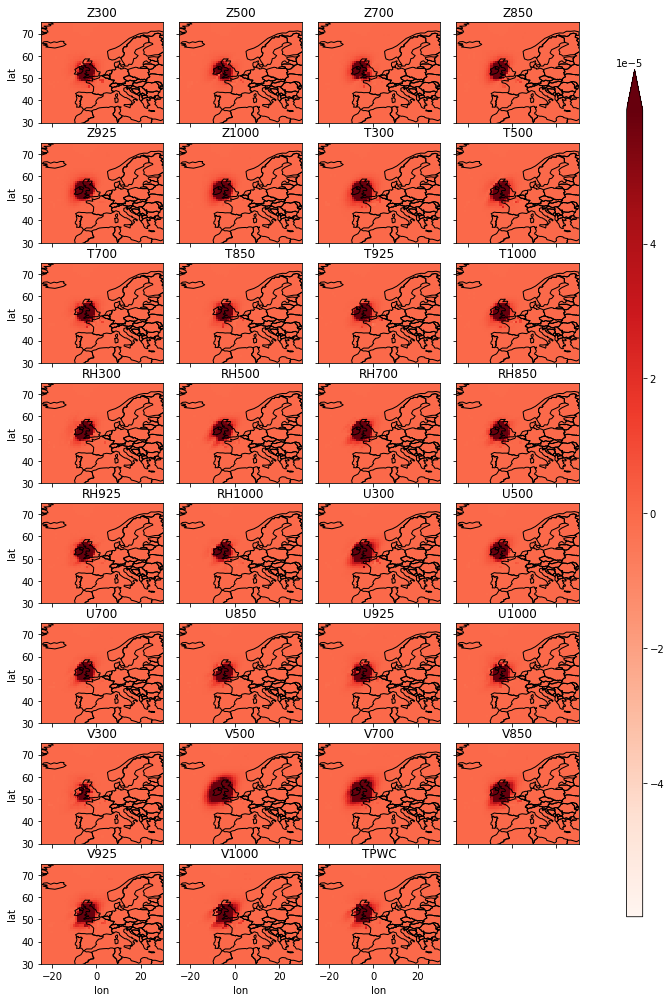

In [27]:
plot_xr_rel(rel_U4_alpha_2018[0,:,:,:], lats_y, lons_x, conf['varnames'], 'highest_amount_precip_alphabeta')

In [ ]:
#Plot input dadta
plot_xr_rel(dg_test_X[i_max_obs], lats_y, lons_x, conf['varnames'], 'highest_amount_precip', cmap = 'viridis', plot=False)

In [ ]:
# Plot average of relevance -all input variables
rel_U4_avg2018 = rel_U4_2018.mean(axis=3)

In [ ]:
idates21 = times[idx-1:idx+2]

In [ ]:
idates21

In [ ]:
mx= xr.DataArray(rel_U4_avg2021, dims=["time","lat", "lon"],
                  coords=dict(time=idates21, lat = lats_y, 
            lon = lons_x))
g = mx.plot.pcolormesh("lon", "lat", col="time", col_wrap=3, robust=True, cmap='Reds',
    yincrease = False, extend='max',figsize=(20, 8),  cbar_kwargs={"orientation": "vertical","shrink": 0.6,"aspect": 15})
    #figsize=(14, 12)
for ax, title in zip(g.axes.flat, idates21):
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world.boundary.plot(ax=ax, lw=1, color='k')
    ax.set_xlim(min(lons_x), max(lons_x))
    ax.set_title(title)
    ax.set_ylim(min(lats_y), max(lats_y))
plt.savefig('figures/episode_2021_storms.pdf')

In [ ]:
rel_U4_avg2018 = rel_U4_alpha_2018.mean(axis=3)

In [ ]:
rel_U4_avg2018.shape

In [ ]:
# Plot averages

In [ ]:
idates = times[i_max_obs:i_max_obs+3]

In [ ]:
mx= xr.DataArray(rel_U4_avg2018, dims=["time","lat", "lon"],
                  coords=dict(time=idates, lat = lats_y, 
            lon = lons_x))
g = mx.plot.pcolormesh("lon", "lat", col="time", col_wrap=3, robust=True, cmap='Reds',
    yincrease = False, extend='max',figsize=(20, 8),  cbar_kwargs={"orientation": "vertical","shrink": 0.6,"aspect": 15})
    #figsize=(14, 12)
for ax, title in zip(g.axes.flat, idates):
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world.boundary.plot(ax=ax, lw=1, color='k')
    ax.set_xlim(min(lons_x), max(lons_x))
    ax.set_title(title)
    ax.set_ylim(min(lats_y), max(lats_y))
plt.savefig('figures/episode_2018_storms.pdf')

In [21]:
### PART 2: Assess model baseline

# event 2021
relBS_U4comp_2021= calLRP(dg_test_X[idx-1:idx+2,:,:,:],m1.model, 'comp', only_positive=False )
# event 2018
relBS_U4comp_2018= calLRP(dg_test_X[i_max_obs:i_max_obs+3,:,:,:],m1.model, 'comp', only_positive=False )

In [24]:
# precipitation amount
# event 2021
relBS_U4comp_2021_pr= calLRP(dg_test_X[idx-1:idx+2,:,:,:],m2.model, 'comp', only_positive=False )
# event 2018
relBS_U4comp_2018_pr= calLRP(dg_test_X[i_max_obs:i_max_obs+3,:,:,:],m2.model, 'comp', only_positive=False )

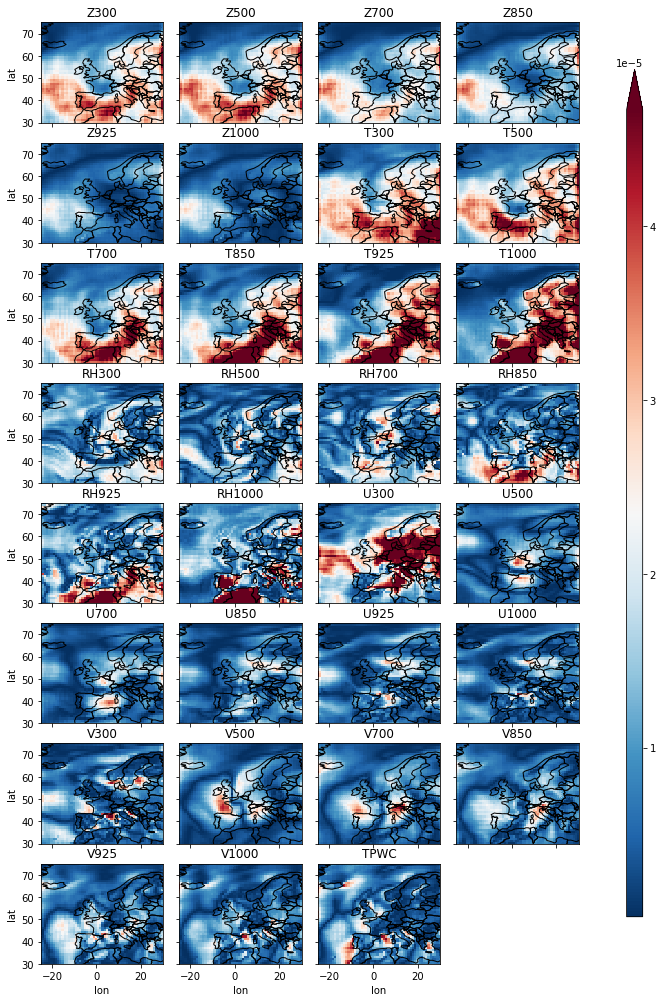

In [22]:
plot_xr_rel(relBS_U4comp_2021[0,:,:,:], lats_y, lons_x, conf['varnames'], 'highest_amount_precip_comp', cmap = 'RdBu_r')